In [1]:

import dataset_utils

import albumentations as albu
import cv2
import math
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
import pytorch_lightning
import pytorchvideo
import random
import shutil
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

##from torchvision.models.video import MViT, S3D
#from torchvision.models.video.resnet import VideoResNet
##from torchvision.models.video.swin_transformer import SwinTransformer3d


C:\Users\n.litvinenko\PycharmProjects\In-vivo_blood_count\venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# Paths & variables :

DATASET_PATH = os.path.join('D:\\','Capillaroscopy')
CAPILLAROSCOPY_PATH = os.path.join(DATASET_PATH, 'FullDataset_nf_gc_1000x1000x3')
MASKS_PATH = os.path.join(DATASET_PATH, 'FullDataset_nf_gc_1000x1000x3_Masks')
DF_PATH = os.path.join(CAPILLAROSCOPY_PATH, 'Application_form.xlsx')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

TRAIN_VAL_TEST_RATIO = (4, 1, 1)
TRAIN_VAL_TEST_FEMALES = (7, 3, 3)
TRAIN_VAL_TEST_SMOKERS = (9, 3, 3)

LEARNING_RATE = 1e-3 # 1e-5 # 1e-4
NUM_OF_EPOCHS = 50 # 100 # 300

BATCH_SIZE = 2 # 4
VIDEO_LENGTH = 200 # 100
FRAME_SIZE = (1000, 1000)
TRANSFORM_RESIZE = (1024, 1024) # (224, 224)
WORK_DIR = os.path.join('C:\\', 'Users', 'n.litvinenko', 'PycharmProjects', 'in-vivo_blood_count', '1-2_Baseline_by_Nikita_Litvinenko')
MODELS_DIR = os.path.join(WORK_DIR, 'models')
HISTORY_DIR = os.path.join(WORK_DIR, 'history')

NEW_DATASET_PATH = os.path.join(WORK_DIR, 'new_dataset')

TRAIN_PATH = os.path.join(NEW_DATASET_PATH, 'train')
VAL_PATH = os.path.join(NEW_DATASET_PATH, 'val')
TEST_PATH = os.path.join(NEW_DATASET_PATH, 'test')

METRIC_FN = accuracy_score
METRIC_NAME = "Accuracy"


In [3]:
def get_white_px(crop):
    return crop['white_px']

def check_cuda():
    print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
    print(f'torch.cuda.device_count(): {torch.cuda.device_count()}')
    print(f'torch.cuda.current_device(): {torch.cuda.current_device()}')

n_cpu = os.cpu_count()
print(f'n_cpu: {n_cpu}')
check_cuda()

n_cpu: 20
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
torch.cuda.current_device(): 0


In [ ]:
"""

(Сделать новый тип преобразования (аугментации) изображений с использованием масок капилляров в виде transform класса с ориентировочным название rangedResizedCrop, 
обновить с учетом этого класс Dataset (до сл. совещания))

- обновить репозиторий (https://github.com/avkornaev/In-vivo_blood_count), добавить туда последнюю версию генератора искусственного датасета (броуновское движение частиц),
обновить версию программы для сегментации, в идеале туда же добавить модуль автоматического подсчета био метрик капилляров от @nikitacherepkin;
- в основной программе сделать собственный класс аугментации rangedResizedCrop с настройками (crop size, crop scale, color jitter, random noise, shuffle, minRank, ...);
- в основной программе обновить класс Dataset, обеспечить возможность увеличения объема обучающих данных, возможность реализации Curriculum learning.

"""

In [4]:
# Define the transforms to be applied to each frame

# mean = [0.43216, 0.394666, 0.37645] ; std = [0.22803, 0.22145, 0.216989] ??
# mean = [0.485, 0.456, 0.406] ; std=[0.229, 0.224, 0.225] ?? mean=0.449 ; std=0.226

DATASET_OPTIONS = dict(RAW_FRAMES = 0, RANGED_CROPS = 1, EQUAL_CROPS = 2, BOUNDING_BOXES = 3)
"""
DATASET_OPTIONS_PARAMS = dict(DATASET_OPTIONS['RAW_FRAMES'] = dict(),
                              DATASET_OPTIONS['RANGED_CROPS'] = dict(CROP_SIZE = (200, 200),
                                                                     NON_ZERO_THRESHOLD_COEFF = 0.001,
                                                                     NON_ZERO_THRESHOLD = int(CROP_SIZE[0]*CROP_SIZE[1]*NON_ZERO_THRESHOLD_COEFF),
                                                                     RANDOM_CROPS_PER_FRAME = 200),
                              DATASET_OPTIONS['EQUAL_CROPS'] = dict(),
                              DATASET_OPTIONS['BOUNDING_BOXES'] = dict())
"""
DATASET_OPTIONS_PARAMS = dict(RAW_FRAMES = dict(),
                              RANGED_CROPS = dict(RANDOM_CROPS_PER_FRAME = 300, CROP_SIZE = (128, 128), MIN_RANK = 3),
                              EQUAL_CROPS = dict(CROPS_DIM = (8, 8)),
                              BOUNDING_BOXES = dict())

GENDER = 'Gender'
IS_SMOKING = 'is_smoking'
BLOOD_TYPE = 'BloodType'
RH_POS = 'BloodType_RHpos'
RH_NEG = 'BloodType_RHneg'
RH = 'Rh_factor'

AGE = 'Age'
HCT = 'HCT'
HGB = 'HGB'
RBC = 'RBC'
MCV = 'MCV'
RDW = 'RDW'
MCH = 'MCH'
MCHC = 'MCHC'
PLT = 'PLT'
WBC = 'WBC'
NEUT_P = 'NEUT%'
LYMP_P = 'LYMP%'
MONO_P = 'MONO%'
EOS_P = 'EOS%'
BASO_P = 'BASO%'
NEUT = 'NEUT'
LYMP = 'LYMP'
MONO = 'MONO'
EOS = 'EOS'
BASO = 'BASO'
ESR = 'ESR'

MALE = 'Male'
FEMALE = 'Female'

NF_DIR_NAME = 'local_path_Nailfold_gc'
TRAIN_VAL_TEST = 'is_val_or_test_set'
FOLD_NF_GC = 'fold_nf_gc'
IMAGE_RATING = 'Image_rating'

CAT_LABELS = (GENDER, IS_SMOKING, BLOOD_TYPE, RH)
NUM_LABELS = (AGE, HCT, HGB, RBC, MCV, RDW, MCH, MCHC, PLT, WBC, NEUT_P, LYMP_P, MONO_P, EOS_P, BASO_P, NEUT, LYMP, MONO, EOS, BASO, ESR)
LABELS_THRESHOLDS = dict(WBC=6.11, ESR=5, HCT=42.7)
GT_MASKS_NUMBERS = (0, 499)


In [5]:
LABEL_NAME = IS_SMOKING

df = pd.read_excel(DF_PATH, engine='openpyxl')
df = df.dropna(how='all')
df = df.iloc[(df[NF_DIR_NAME] != 0).to_numpy(), :]
pd.set_option('display.max_rows', len(df))


In [6]:
df.index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 64],
      dtype='int64')

In [7]:
len(df.index)

62

In [8]:
TRAIN_DF_SIZE, VAL_DF_SIZE, TEST_DF_SIZE = dataset_utils.get_train_val_test_sizes(df.index, TRAIN_VAL_TEST_RATIO)
print(f'TRAIN_DF_SIZE: {TRAIN_DF_SIZE}, VAL_DF_SIZE: {VAL_DF_SIZE}, TEST_DF_SIZE: {TEST_DF_SIZE}')

"""
TRAIN_VAL_TEST_MALES = TRAIN_DF_SIZE - TRAIN_VAL_TEST_FEMALES[0], VAL_DF_SIZE - TRAIN_VAL_TEST_FEMALES[1], TEST_DF_SIZE - TRAIN_VAL_TEST_FEMALES[2]
print(f'TRAIN_DF_SIZE: {TRAIN_DF_SIZE}, VAL_DF_SIZE: {VAL_DF_SIZE}, TEST_DF_SIZE: {TEST_DF_SIZE}')
print(f'TRAIN_VAL_TEST_MALES: {TRAIN_VAL_TEST_MALES}')
print(f'TRAIN_VAL_TEST_FEMALES: {TRAIN_VAL_TEST_FEMALES}')
"""

"""
TRAIN_VAL_TEST_NONSMOKERS = TRAIN_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[0], VAL_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[1], TEST_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[2]
print(f'TRAIN_DF_SIZE: {TRAIN_DF_SIZE}, VAL_DF_SIZE: {VAL_DF_SIZE}, TEST_DF_SIZE: {TEST_DF_SIZE}')
print(f'TRAIN_VAL_TEST_SMOKERS: {TRAIN_VAL_TEST_SMOKERS}')
print(f'TRAIN_VAL_TEST_NONSMOKERS: {TRAIN_VAL_TEST_NONSMOKERS}')
"""

TRAIN_DF_SIZE: 42, VAL_DF_SIZE: 10, TEST_DF_SIZE: 10


"\nTRAIN_VAL_TEST_NONSMOKERS = TRAIN_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[0], VAL_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[1], TEST_DF_SIZE - TRAIN_VAL_TEST_SMOKERS[2]\nprint(f'TRAIN_DF_SIZE: {TRAIN_DF_SIZE}, VAL_DF_SIZE: {VAL_DF_SIZE}, TEST_DF_SIZE: {TEST_DF_SIZE}')\nprint(f'TRAIN_VAL_TEST_SMOKERS: {TRAIN_VAL_TEST_SMOKERS}')\nprint(f'TRAIN_VAL_TEST_NONSMOKERS: {TRAIN_VAL_TEST_NONSMOKERS}')\n"

In [9]:
#male_df = df[df[LABEL_NAME] == CapillaroscopyDataset.MALE]
#len(male_df)
smokers_df = df[df[LABEL_NAME] == 1]
len(smokers_df)

15

In [10]:
#female_df = df[df[LABEL_NAME] == CapillaroscopyDataset.FEMALE]
#len(female_df)
nonsmokers_df = df[df[LABEL_NAME] == 0]
len(nonsmokers_df)

47

In [11]:
#(df[LABEL_NAME] == CapillaroscopyDataset.FEMALE).to_numpy().astype(np.int64)
(df[LABEL_NAME]).to_numpy().astype(np.int64)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1], dtype=int64)

In [12]:
#female_df.index
smokers_df.index

Index([0, 1, 17, 20, 22, 23, 31, 32, 33, 35, 36, 44, 54, 57, 64], dtype='int64')

In [13]:

#all_train_indices, all_val_indices, all_test_indices = dataset_utils.get_train_val_test_indices(male_df.index, female_df.index, TRAIN_VAL_TEST_MALES, TRAIN_VAL_TEST_FEMALES)

#all_train_indices, all_val_indices, all_test_indices = dataset_utils.get_train_val_test_indices(smokers_df.index, nonsmokers_df.index, TRAIN_VAL_TEST_SMOKERS, TRAIN_VAL_TEST_NONSMOKERS)

#print(f'all_train_indices : {all_train_indices}')
#print(f'all_val_indices : {all_val_indices}')
#print(f'all_test_indices : {all_test_indices}')

train_indices, val_indices, test_indices = dataset_utils.get_train_val_test_from_ratio(df.index, TRAIN_VAL_TEST_RATIO)
print(f'train_indices : {train_indices}')
print(f'val_indices : {val_indices}')
print(f'test_indices : {test_indices}')

train_indices : {0, 1, 3, 5, 6, 7, 10, 13, 16, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 43, 45, 46, 47, 50, 52, 53, 55, 56, 57, 58, 60, 61, 64}
val_indices : {9, 42, 44, 15, 49, 19, 51, 22, 59, 62}
test_indices : {33, 2, 4, 39, 8, 41, 11, 48, 17, 54}


is_smoking :  min: 0.0 median: 0.0 max: 1.0


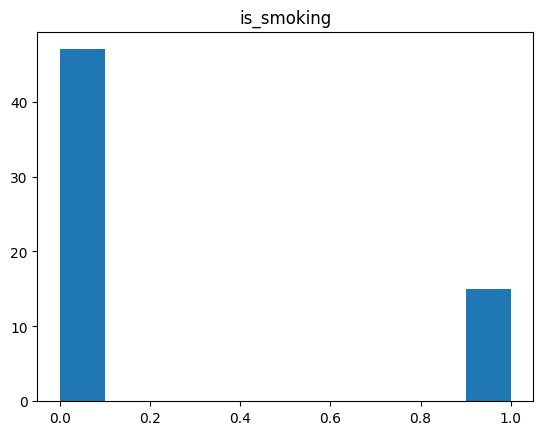

In [14]:
plt.hist(np.array(df[LABEL_NAME]))
plt.title(LABEL_NAME)
print(f'{LABEL_NAME} :  min: {df[LABEL_NAME].min()} median: {df[LABEL_NAME].median()} max: {df[LABEL_NAME].max()}')

min 0.0 median 0.0 max 1.0


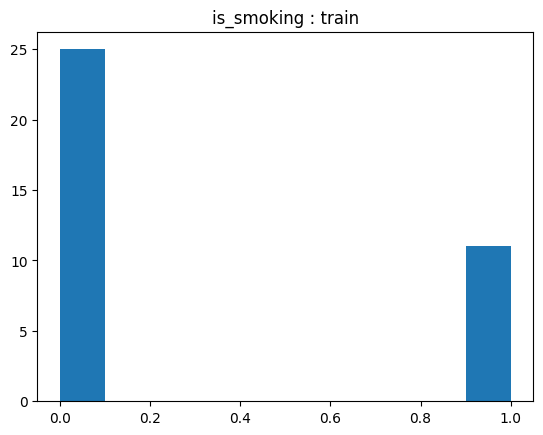

In [15]:
dataset_utils.plot_hist(df, tit=LABEL_NAME, dest='train')

min 0.0 median 0.0 max 1.0


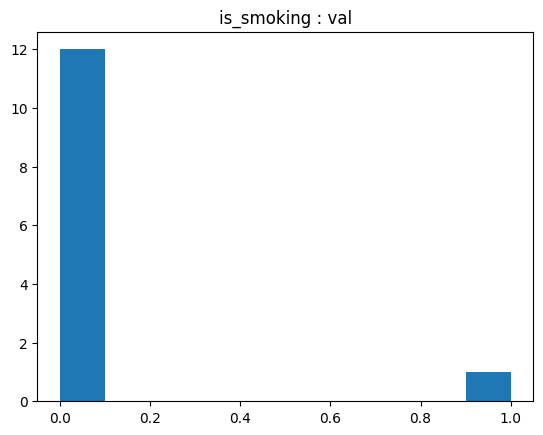

In [16]:
dataset_utils.plot_hist(df, tit=LABEL_NAME, dest='val')

min 0.0 median 0.0 max 1.0


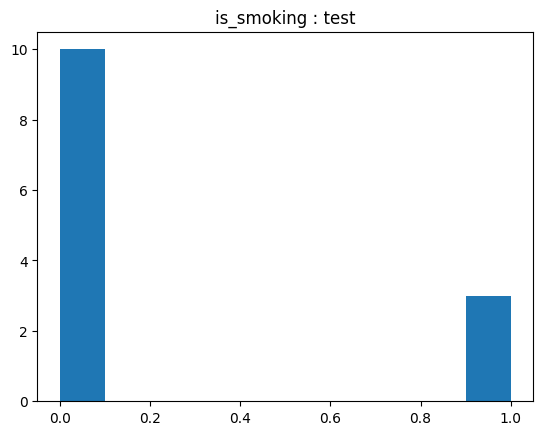

In [17]:
dataset_utils.plot_hist(df, tit=LABEL_NAME, dest='test')

In [18]:
"""
train_df = df[df.index.isin(all_train_indices)]
val_df = df[df.index.isin(all_val_indices)]
test_df = df[df.index.isin(all_test_indices)]
"""

train_df = df[df.index.isin(train_indices)]
val_df = df[df.index.isin(val_indices)]
test_df = df[df.index.isin(test_indices)]

In [19]:
train_df

,Sex,Age,is_smoking,BloodType_RHpos,BloodType_RHneg,BloodType,HCT,HGB,RBC,MCV,...,MONO,EOS,BASO,ESR,BloodType.1,init_URL_Nailfold_cc,local_path_Nailfold_gc,is_val_or_test_set,fold_nf_gc,Notes
0,Male,25,1.0,3,0,3,45.3,16.8,5.60,80.9,...,0.80,0.33,0.12,3.0,NaN,/Cell Lab/Blood_count_2022/25.01.2022/sin_nf_2...,sin_nf_25.01.2022_2p5_gc,test,1,NaN
1,Male,22,1.0,2,0,2,40.6,14.3,4.63,87.7,...,0.53,0.14,0.03,4.0,NaN,/Cell Lab/Blood_count_2022/25.01.2022/chna_nf_...,chna_nf_25.01.2022_2p5_gc,train,1,NaN
3,Male,50,0.0,1,0,1,40.6,14.3,4.63,87.7,...,0.53,0.14,0.03,4.0,NaN,/Cell Lab/Blood_count_2022/26.01.2022/gav_nf_2...,gav_nf_26.01.2022_2p5_gc,train,0,bad_nailfold
5,Male,20,0.0,2,0,2,47.6,15.7,5.92,80.4,...,0.64,0.25,0.08,5.0,NaN,/Cell Lab/Blood_count_2022/26.01.2022/nkk_nf_2...,nkk_nf_26.01.2022_2p5_gc,train,1,NaN
6,Male,22,0.0,0,1,1,41.6,14.6,5.04,82.5,...,0.58,0.04,0.05,4.0,1.0,/Cell Lab/Blood_count_2022/25.01.2022/kyun_nf_...,kyun_nf_25.01.2022_2p5_gc,train,1,NaN
7,Female,61,0.0,3,0,3,38.4,12.9,4.78,80.3,...,0.39,0.13,0.03,25.0,NaN,/Cell Lab/Blood_count_2022/11.02.2022/knm_nf_1...,knm_nf_11.02.2022_2p5_gc,train,0,bad_nailfold
10,Male,40,0.0,1,0,1,41.9,14.4,4.82,86.9,...,0.47,0.14,0.03,4.0,NaN,/Cell Lab/Blood_count_2022/25.01.2022/kav_nf_2...,kav_nf_25.01.2022_2p5_gc,train,1,NaN
13,Male,40,0.0,1,0,1,42.7,14.3,4.84,88.2,...,0.49,0.10,0.02,7.0,NaN,/Cell Lab/Blood_count_2022/18.02.2022/kav_nf_1...,kav_nf_18.02.2022_2p5_gc,train,1,NaN
16,Male,27,0.0,3,0,3,44.9,15.6,5.46,82.2,...,0.51,0.07,0.05,5.0,3.0,/Cell Lab/Blood_count_2022/18.02.2022/psg_nf_1...,psg_nf_18.02.2022_2p5_gc,train,2,NaN
18,Male,26,0.0,1,0,1,46.1,15.2,5.39,85.5,...,0.71,0.09,0.03,6.0,NaN,/Cell Lab/Blood_count_2022/18.02.2022/zrk_nf_1...,zrk_nf_18.02.2022_2p5_gc,train,2,nailfold is not really good


In [20]:
val_df

,Sex,Age,is_smoking,BloodType_RHpos,BloodType_RHneg,BloodType,HCT,HGB,RBC,MCV,...,MONO,EOS,BASO,ESR,BloodType.1,init_URL_Nailfold_cc,local_path_Nailfold_gc,is_val_or_test_set,fold_nf_gc,Notes
9,Female,35,0.0,3,0,3,43.1,14.5,5.04,85.5,...,0.44,0.04,0.03,5.0,NaN,/Cell Lab/Blood_count_2022/25.01.2022/kep_nf_2...,kep_nf_25.01.2022_2p5_gc,train,1,NaN
15,Male,28,0.0,1,0,1,43.5,15.4,5.46,79.7,...,0.54,0.03,0.02,9.0,NaN,/Cell Lab/Blood_count_2022/18.02.2022/fas_nf_1...,fas_nf_18.02.2022_2p5_gc,train,1,NaN
19,Male,21,0.0,0,0,0,45.3,15.9,5.48,82.7,...,0.59,0.10,0.02,6.0,NaN,/Cell Lab/Blood_count_2022/16.02.2022/lmg_nf_1...,lmg_nf_16.02.2022_2p5_gc,train,2,NaN
22,Male,21,1.0,2,0,2,44.7,15.9,5.02,89.0,...,0.75,0.16,0.06,5.0,NaN,/Cell Lab/Blood_count_2022/16.02.2022/udo_nf_1...,udo_nf_16.02.2022_2p5_gc,train,2,NaN
42,Female,19,0.0,1,0,1,34.1,11.6,4.09,83.4,...,0.46,0.04,0.07,11.0,NaN,/Cell Lab/Blood_count_2022/25.02.2022/elv_nf_2...,elv_nf_25.02.2022_2p5_gc,train,4,NaN
44,Male,21,1.0,0,0,0,42.7,15.3,4.73,90.3,...,0.54,0.06,0.05,5.0,NaN,/Cell Lab/Blood_count_2022/25.02.2022/kds_nf_2...,kds_nf_25.02.2022_2p5_gc,train,4,NaN
49,Male,24,0.0,0,0,0,46.3,16.1,5.41,85.6,...,0.36,0.12,0.03,5.0,NaN,/Cell Lab/Blood_count_2022/24.02.2022/sns_nf_2...,sns_nf_24.02.2022_2p5_gc,val,5,NaN
51,Male,19,0.0,0,0,0,42.8,14.6,5.31,80.6,...,0.61,0.11,0.05,3.0,NaN,/Cell Lab/Blood_count_2022/25.02.2022/lpi _nf_...,lpi_nf_25.02.2022_2p5_gc,train,5,NaN
59,Male,19,0.0,0,0,0,40.4,14.2,4.71,85.8,...,0.40,0.05,0.02,9.0,NaN,/Cell Lab/Blood_count_2022/25.02.2022/sia_nf_2...,sia_nf_25.02.2022_2p5_gc,val,5,NaN
62,Female,20,0.0,1,0,1,37.5,12.9,4.34,86.4,...,0.83,0.20,0.05,6.0,NaN,/Cell Lab/Blood_count_2022/22.02.2022/nea_nf_2...,nea_nf_22.02.2022_2p5_gc,train,5,NaN


In [21]:
test_df

,Sex,Age,is_smoking,BloodType_RHpos,BloodType_RHneg,BloodType,HCT,HGB,RBC,MCV,...,MONO,EOS,BASO,ESR,BloodType.1,init_URL_Nailfold_cc,local_path_Nailfold_gc,is_val_or_test_set,fold_nf_gc,Notes
2,Male,20,0.0,3,0,3,45.2,15.2,5.44,83.1,...,0.52,0.06,0.03,4.0,NaN,/Cell Lab/Blood_count_2022/26.01.2022/liv_nf_2...,liv_nf_26.01.2022_2p5_gc,test,1,NaN
4,Female,21,0.0,1,0,1,35.3,12.3,4.03,87.6,...,0.50,0.11,0.06,15.0,NaN,/Cell Lab/Blood_count_2022/26.01.2022/gpp_nf_2...,gpp_nf_26.01.2022_2p5_gc,test,1,NaN
8,Female,22,0.0,1,0,1,38.6,12.9,4.66,82.8,...,0.29,0.06,0.02,17.0,NaN,/Cell Lab/Blood_count_2022/11.02.2022/lyui_nf_...,lyui_nf_11.02.2022_2p5_gc,train,0,bad_nailfold
11,Female,23,0.0,1,0,1,37.6,12.6,4.54,82.8,...,0.48,0.09,0.04,11.0,NaN,/Cell Lab/Blood_count_2022/11.02.2022/gnv_nf_1...,gnv_nf_11.02.2022_2p5_gc,val,1,NaN
17,Male,24,1.0,2,0,2,47.9,17.1,5.46,87.7,...,0.47,0.09,0.07,8.0,NaN,/Cell Lab/Blood_count_2022/18.02.2022/shvv_nf_...,shvv_nf_18.02.2022_2p5_gc,train,2,NaN
33,Male,20,1.0,0,0,0,43.3,15.5,5.07,85.4,...,0.47,0.18,0.05,6.0,NaN,/Cell Lab/Blood_count_2022/22.02.2022/kas_nf_2...,kas_nf_22.02.2022_2p5_gc,test,3,NaN
39,Female,28,0.0,0,0,0,40.9,13.3,4.68,87.4,...,0.34,0.10,0.05,10.0,NaN,/Cell Lab/Blood_count_2022/24.02.2022/tov_nf_2...,tov_nf_24.02.2022_2p5_gc,val,4,nailfold is not really good
41,Male,19,0.0,0,1,1,41.2,14.5,5.17,79.7,...,0.56,0.24,0.03,6.0,NaN,/Cell Lab/Blood_count_2022/25.02.2022/apyu_nf_...,apyu_nf_25.02.2022_2p5_gc,val,4,NaN
48,Male,9,0.0,1,0,1,42.8,14.9,5.49,78.0,...,0.45,0.26,0.03,9.0,NaN,/Cell Lab/Blood_count_2022/24.02.2022/pdr_nf_2...,pdr_nf_24.02.2022_2p5_gc,test,4,NaN
54,Male,22,1.0,0,0,0,41.6,15.1,4.88,85.2,...,0.37,0.08,0.02,8.0,NaN,/Cell Lab/Blood_count_2022/25.02.2022/tve_nf_2...,tve_nf_25.02.2022_2p5_gc,train,0,no_wrist


In [ ]:

def make_new_dataset(new_path, ratio, label_ratio=None, label=LABEL_NAME, data_path=CAPILLAROSCOPY_PATH, df_path=DF_PATH):
    new_folders_symlinks = dict(train = [], val = [], test = [])
    df = pd.read_excel(DF_PATH, engine='openpyxl')
    df = df.dropna(how='all')
    df = df.iloc[(df[NF_DIR_NAME] != 0).to_numpy(), :]
    os.makedirs(new_path, exist_ok=True)
    train_df_size, val_df_size, test_df_size = dataset_utils.get_train_val_test_sizes(df.index, ratio)
    
    if label_ratio is None:
        pass
    else:
        pass
    

    return new_folders_links


new_folders_links = make_new_dataset(NEW_DATASET_PATH, TRAIN_VAL_TEST_RATIO, TRAIN_VAL_TEST_SMOKERS)
print(f'new_folders_links: {new_folders_links}')



In [ ]:

class NVC_DataModule(pytorch_lightning.LightningDataModule):

  # Dataset configuration
  _DATA_PATH = <path_to_kinetics_data_dir>
  _CLIP_DURATION = 2  # Duration of sampled clip for each video
  _BATCH_SIZE = 8
  _NUM_WORKERS = 8  # Number of parallel processes fetching data

  def train_dataloader(self):
    """
    Create the Kinetics train partition from the list of video labels
    in {self._DATA_PATH}/train
    """
    train_dataset = pytorchvideo.data.LabeledVideoDataset(
        data_path=TRAIN_PATH,
        clip_sampler=pytorchvideo.data.make_clip_sampler("random", self._CLIP_DURATION),
        decode_audio=False
    )
    return torch.utils.data.DataLoader(
        train_dataset,
        batch_size=self._BATCH_SIZE,
        num_workers=self._NUM_WORKERS
    )

  def val_dataloader(self):
    """
    Create the Kinetics validation partition from the list of video labels
    in {self._DATA_PATH}/val
    """
    val_dataset = pytorchvideo.data.LabeledVideoDataset(
        data_path=VAL_PATH,
        clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", self._CLIP_DURATION),
        decode_audio=False
    )
    return torch.utils.data.DataLoader(
        val_dataset,
        batch_size=self._BATCH_SIZE,
        num_workers=self._NUM_WORKERS
    )


In [25]:
# 'RAW_FRAMES'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(HISTORY_DIR, exist_ok=True)

train_dataset = CapillaroscopyDataset(CAPILLAROSCOPY_PATH, MASKS_PATH, train_df, LABEL_NAME, CapillaroscopyDataset.DATASET_OPTIONS['RANGED_CROPS'], video_length=VIDEO_LENGTH, transforms=RANGED_CROPS_TRANSFORMS)# , transforms=transforms)
val_dataset = CapillaroscopyDataset(CAPILLAROSCOPY_PATH, MASKS_PATH, val_df, LABEL_NAME, CapillaroscopyDataset.DATASET_OPTIONS['RANGED_CROPS'], video_length=VIDEO_LENGTH)# , transforms=transforms)
test_dataset = CapillaroscopyDataset(CAPILLAROSCOPY_PATH, MASKS_PATH, test_df, LABEL_NAME, CapillaroscopyDataset.DATASET_OPTIONS['RANGED_CROPS'], video_length=VIDEO_LENGTH)# , transforms=transforms)

print(f'len(train_dataset), len(val_dataset), len(test_dataset) : {len(train_dataset)}, {len(val_dataset)}, {len(test_dataset)}')
print(f'train_dataset.get_targets() : \n{train_dataset.get_targets().numpy()}')
print(f'val_dataset.get_targets() : \n{val_dataset.get_targets().numpy()}')
print(f'test_dataset.get_targets() : \n{test_dataset.get_targets().numpy()}')

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers=n_cpu)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, num_workers=n_cpu)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, num_workers=n_cpu)


len(train_dataset), len(val_dataset), len(test_dataset) : 42, 10, 10
train_dataset.get_targets() : 
[1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1]
val_dataset.get_targets() : 
[1 0 0 0 0 0 0 0 1 0]
test_dataset.get_targets() : 
[0 0 0 0 0 0 0 0 0 1]


In [26]:

def plot_cm(model, loader, title):
    """Show confusion matrix for predictions of model on loader data.

    Args:
        model (Model): Model for predictions.
        loader (DataLoader): Loader with data.
        title (str): Title of CM.
    """

    plt.figure()

    with torch.no_grad():
        labels, preds = predict(loader, model)

    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, figsize=(2.5, 2.5), cmap=plt.cm.Blues)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title + " CM")
    plt.show()


def plot_train_history(history, metric_name):
    """Plot train history.

    Args:
        history (dict): Dict of lists with train history.
        metric_name (str): Name of metric.
    """

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(17, 10))

    ax[0].plot(history['Train loss'], c='r')
    ax[0].plot(history['Val loss'], c='g')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'])

    ax[1].plot(history[f'Train {metric_name}'], c='r')
    ax[1].plot(history[f'Val {metric_name}'], c='g')
    ax[1].set_title(metric_name)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].legend(['Train', 'Val'])

    plt.show()


def evaluate(model, loader, criterion, metric_fn):
    """Make model evaluation on loader data.

    Args:
        model (Model): Current model.
        loader (DataLoader): DataLoader with data for predictions.
        criterion (callable): Function for loss calculation.
        metric_fn (callable): Function for metric calculation.

    Returns:
        tuple: (loss, metric):
            loss (float): Value of loss.
            metric (float): Value of metric.
    """

    model.eval()

    labels_all = None
    outputs = None
    outputs_clean = None

    sm = torch.nn.Softmax(dim=1)

    for images, labels in iter(loader):
        if torch.cuda.is_available():
            images, labels = images.to(DEVICE), labels.to(DEVICE)

        output = sm(model.forward(images)).argmax(1)

        output_clean = model.forward(images)
        if outputs is not None:
            outputs_clean = torch.cat((outputs_clean, output_clean.cpu()), 0)
            outputs = torch.cat((outputs, output.cpu()), 0)
            labels_all = torch.cat((labels_all, labels.cpu()), 0)
        else:
            outputs = output.cpu()
            outputs_clean = output_clean.cpu()
            labels_all = labels.cpu()

    model = None
    images = None
    labels = None
    output = None
    sm = None

    torch.cuda.empty_cache()

    return criterion(outputs_clean, labels_all), metric_fn(labels_all, outputs)


def predict(loader, model):
    """Make model predictions on loader data.

    Args:
        loader (DataLoader): DataLoader with data for predictions.
        model (Model): Current model.

    Returns:
        tuple: (act_classes, pred_classes):
            act_classes (list): List of actual classes.
            pred_classes (list): List of predicted classes.
    """

    model.eval()

    act_classes = None
    pred_classes = None

    sm = torch.nn.Softmax(dim=1)

    for images, labels in iter(loader):
        if torch.cuda.is_available():
            images, labels = images.to(DEVICE), labels.to(DEVICE)

        output = sm(model.forward(images)).argmax(1)

        if act_classes is None:
            act_classes = labels.cpu()
            pred_classes = output.cpu()
        else:
            act_classes = torch.cat((act_classes, labels.cpu()))
            pred_classes = torch.cat((pred_classes, output.cpu()))

    model = None
    images = None
    labels = None
    output = None
    sm = None

    torch.cuda.empty_cache()

    return list(act_classes), list(pred_classes)

In [26]:
with torch.no_grad():
    loss, accuracy = evaluate(model, test_loader, criterion, METRIC_FN)
    print(f"Test loss: {loss}, Test {METRIC_NAME}: {accuracy}")

Test loss: 0.7344552874565125, Test Accuracy: 0.4


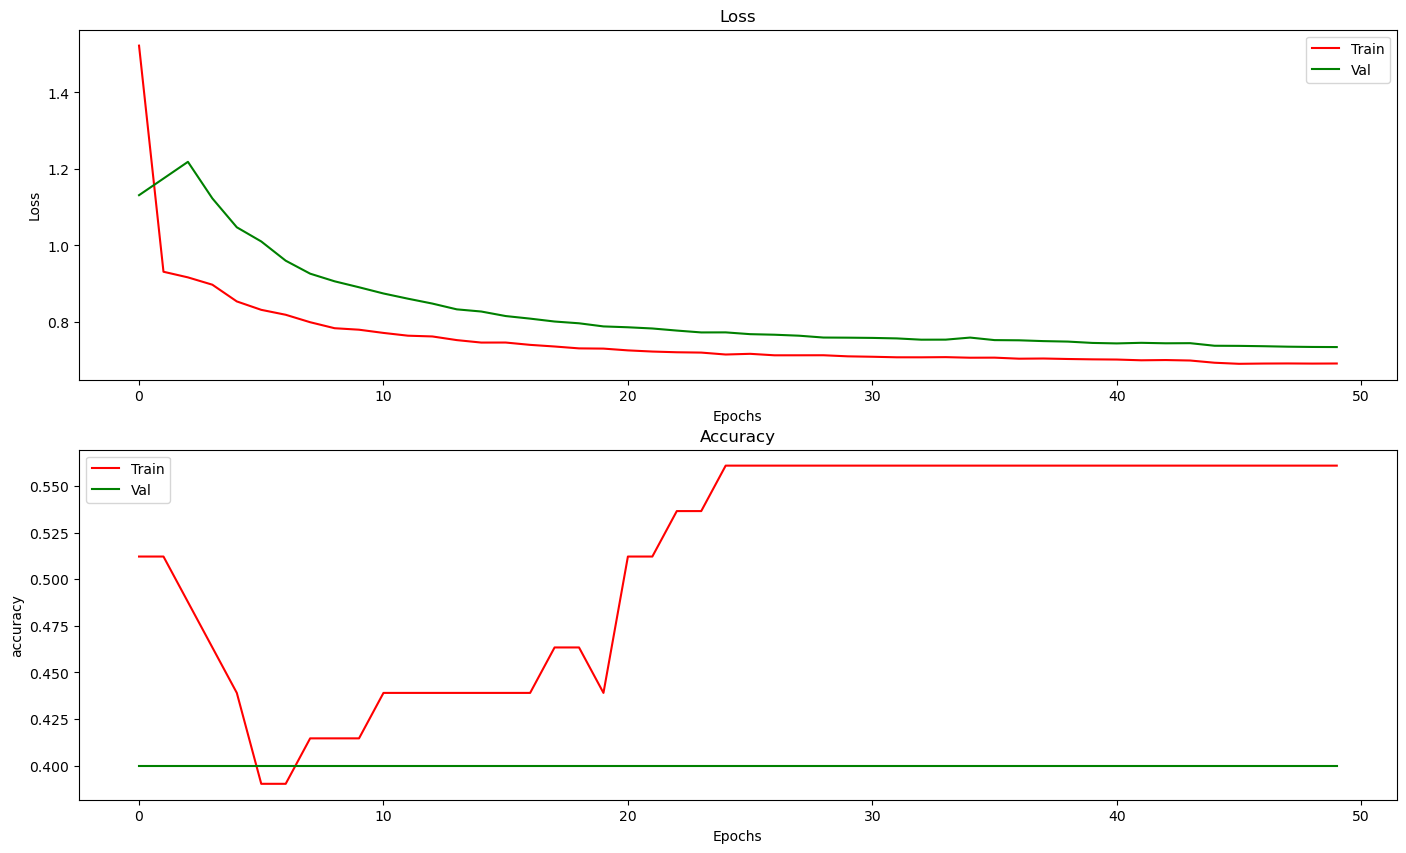

In [27]:
plot_train_history(history, METRIC_NAME)

<Figure size 640x480 with 0 Axes>

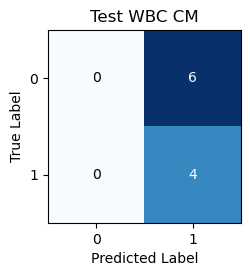

In [28]:
plot_cm(model, test_loader, title=f'Test {LABEL_NAME}')